In [73]:
# Imports
import pathlib
from transformations import (
    ComposeDouble,
    normalize_01,
    AlbuSeg2d,
    FunctionWrapperDouble,
    create_dense_target,
)
from sklearn.model_selection import train_test_split
from customdatasets import TrackDataset
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations as A


In [74]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import FloatProgress

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames

# pre-transformations
pre_transforms = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(64, 64, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(64, 64),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
    ]
)

# training transformations and augmentations
transforms_training = ComposeDouble(
    [                
        AlbuSeg2d(A.RandomBrightnessContrast(p=0.5)),
        AlbuSeg2d(A.HorizontalFlip(p=0.5)),
        AlbuSeg2d(A.ChannelShuffle(p=0.2)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(64, 64, 3)
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(64, 64),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
# random_seed = 42

# # split dataset into training set and validation set
# train_size = 0.8  # 80:20 split


# root directory
train_root = pathlib.Path.cwd() / "dataset_large/train"
val_root = pathlib.Path.cwd() / "dataset_large/val"
# input and target files
inputs_train = get_filenames_of_path(train_root / "images")
targets_train = get_filenames_of_path(train_root / "targets")

inputs_valid = get_filenames_of_path(val_root / "images")
targets_valid = get_filenames_of_path(val_root / "targets")
# inputs_train, inputs_valid = train_test_split(
#     inputs, random_state=random_seed, train_size=train_size, shuffle=True
# )

# targets_train, targets_valid = train_test_split(
#     targets, random_state=random_seed, train_size=train_size, shuffle=True
# )

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = TrackDataset(
    inputs=inputs_train,
    targets=targets_train,
    transform=transforms_training,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataset validation
dataset_valid = TrackDataset(
    inputs=inputs_valid,
    targets=targets_valid,
    transform=transforms_validation,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=8, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=1, shuffle=True)

Caching:   0%|          | 0/932 [00:00<?, ?it/s]

Caching:   0%|          | 0/127 [00:00<?, ?it/s]

In [75]:
import torch.nn as nn
#dice loss function
# class DiceLoss(torch.nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()
#         self.smooth = 1.0

#     def forward(self, y_pred, y_true):
#         print(y_pred.size())
#         print(y_true.size())
#         assert y_pred.size() == y_true.size()
#         y_pred = y_pred[:, 0].contiguous().view(-1)
#         y_true = y_true[:, 0].contiguous().view(-1)
#         intersection = (y_pred * y_true).sum()
#         dsc = (2.*intersection+ elf.smooth)/(y_pred.sum()+y_true.sum()+self.smooth)
#         return 1. - dsc

class MulticlassDiceLoss(nn.Module):
    """Reference: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
    """
    def __init__(self, num_classes, softmax_dim=None):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim
    def forward(self, logits, targets, reduction='mean', smooth=1e-6):
        """The "reduction" argument is ignored. This method computes the dice
        loss for all classes and provides an overall weighted loss.
        """
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)
        # end if
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)
        
        # Convert from NHWC to NCHW
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)
        # print(targets_one_hot.shape)
        # Multiply one-hot encoded ground truth labels with the probabilities to get the
        # prredicted probability for the actual class.
        intersection = (targets_one_hot * probabilities).sum()
        
        mod_a = intersection.sum()
        mod_b = targets.numel()
        
        dice_coefficient = 2. * intersection / (mod_a + mod_b + smooth)
        dice_loss = -dice_coefficient.log()
        # dice_loss = 1 - dice_coefficient
        return dice_loss


# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model
model = UNet(
    in_channels=3,
    out_channels=3,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)

# criterion
# criterion = torch.nn.CrossEntropyLoss()
# criterion = DiceLoss()
criterion = MulticlassDiceLoss(num_classes=3, softmax_dim=1)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=15, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# trainer
trainer = Trainer(
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    training_dataloader=dataloader_training,
    validation_dataloader=dataloader_validation,
    lr_scheduler=scheduler,
    epochs=200,
    epoch=0,
    notebook=True,
    checkpoint_dir=f"experiment_lr_on_plateau_dataset_large_color_aug",
    save_frequency=1
)

In [76]:
training_losses, validation_losses, lr_rates, data = trainer.run_trainer()


Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

Training:   0%|          | 0/117 [00:00<?, ?it/s]

Validation:   0%|          | 0/127 [00:00<?, ?it/s]

[0.0340700540214953, 0.020429298146004516, 0.01793978959193644, 0.010630198396874343, 0.008853126963505185, 0.00933050543278837, 0.007731165108087612, 0.007334415321458336, 0.006903933483087934, 0.007355603562689965, 0.0060997581875729045, 0.060109200363054754, 0.0064752826835652155, 0.009224668331260932, 0.005570272002992492, 0.005535692730955193, 0.011318360803663496, 0.005461044772711443, 0.006432557155884157, 0.004409070308210226, 0.004581032199858445, 0.004105564921830348, 0.004790895750038472, 0.007604383531679202, 0.0047021123995879795, 0.004386373091577076, 0.004500963284238059, 0.006545697096881904, 0.004245437759590724, 0.00405403982213603, 0.004096355804381525, 0.004014138382122536, 0.0036161374598631534, 0.003716662119135378, 0.0038835562817847694, 0.004091279781020181, 0.004328059344222461, 0.0037386460975912493, 0.004229196031966548, 0.005024213685771436, 0.005495746137838312, 0.033068721757387724, 0.004307953068825204, 0.0038812115539129323, 0.003976564869966622, 0.00392

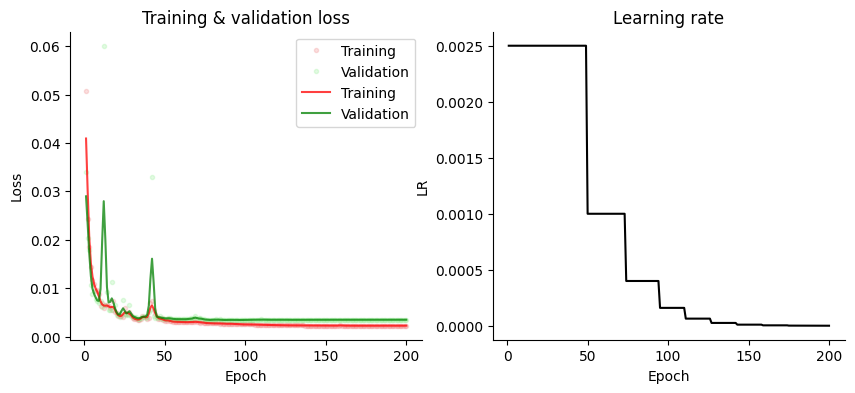

In [79]:
from visual import plot_training

fig = plot_training(
    training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)
print(validation_losses)
print(training_losses)
print(f"best weights at epoch {np.argmin(validation_losses)+1} having loss {np.min(validation_losses)}")

In [78]:
for i in range(len(validation_losses)):
    print(i, validation_losses[i])

0 0.0340700540214953
1 0.020429298146004516
2 0.01793978959193644
3 0.010630198396874343
4 0.008853126963505185
5 0.00933050543278837
6 0.007731165108087612
7 0.007334415321458336
8 0.006903933483087934
9 0.007355603562689965
10 0.0060997581875729045
11 0.060109200363054754
12 0.0064752826835652155
13 0.009224668331260932
14 0.005570272002992492
15 0.005535692730955193
16 0.011318360803663496
17 0.005461044772711443
18 0.006432557155884157
19 0.004409070308210226
20 0.004581032199858445
21 0.004105564921830348
22 0.004790895750038472
23 0.007604383531679202
24 0.0047021123995879795
25 0.004386373091577076
26 0.004500963284238059
27 0.006545697096881904
28 0.004245437759590724
29 0.00405403982213603
30 0.004096355804381525
31 0.004014138382122536
32 0.0036161374598631534
33 0.003716662119135378
34 0.0038835562817847694
35 0.004091279781020181
36 0.004328059344222461
37 0.0037386460975912493
38 0.004229196031966548
39 0.005024213685771436
40 0.005495746137838312
41 0.033068721757387724
4